In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from modules import init_cosmology, init_sample, PNGModel
import healpy as hp
import sys
sys.path.insert(0, '/Users/rezaie/github/LSSutils')
from lssutils.stats.cl import AnaFast
from tqdm.notebook import tqdm

## Generate Truth Power Spectrum

In [2]:
# read n(z), and create the true C_ell
z1, nz1 = np.loadtxt('/Volumes/TimeMachine/data/DR9fnl/nz_qso_rfv2.txt').T # ext=1
z2, nz2 = np.loadtxt('/Volumes/TimeMachine/data/DR9fnl/nz_qso_rf.txt').T   # ext=0
b = 1.6*np.ones_like(z1)

Text(0, 0.5, 'n(z|ext=0)-n(z|ext=1)')

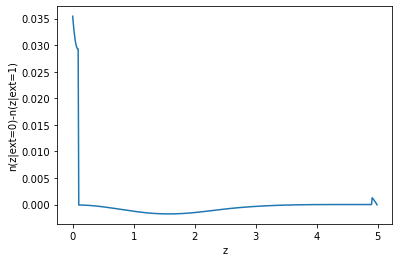

In [3]:
plt.plot(z1, nz2-nz1)

plt.xlabel('z')
plt.ylabel('n(z|ext=0)-n(z|ext=1)')

In [4]:
ell = np.arange(1000)

cosmo = init_cosmology()

model1 = PNGModel(cosmo, has_rsd=True, has_fnl=True)
model1.add_tracer(z1, b, nz1)

#
cl_true = model1(ell, fnl=0.0)
cl_true[0] = 0.0              # set C(ell=0) = 0.0

NOTE: This code uses a cosmology calculator that returns k and P(k) in units of 1/Mpc and Mpc^3.
 Therefore, the coefficient alpha in the model uses H_0 = 100h, not H_0=100.
will create windows


In [5]:
ell = np.arange(1000)

cosmo = init_cosmology()

model2 = PNGModel(cosmo, has_rsd=True, has_fnl=True)
model2.add_tracer(z2, b, nz2)

cl_true2 = model2(ell, fnl=0.0)
cl_true2[0] = 0.0 # set C(ell=0) = 0.0

NOTE: This code uses a cosmology calculator that returns k and P(k) in units of 1/Mpc and Mpc^3.
 Therefore, the coefficient alpha in the model uses H_0 = 100h, not H_0=100.
will create windows


Text(0, 0.5, 'C$_{\\ell}$')

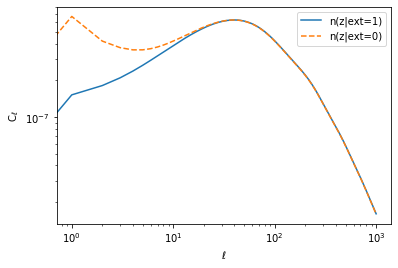

In [8]:
plt.loglog(ell, cl_true,  label='n(z|ext=1)')
plt.loglog(ell, cl_true2, '--', label='n(z|ext=0)')
plt.legend()
plt.xlabel(r'$\ell$')
plt.ylabel(r'C$_{\ell}$')

In [5]:
np.savetxt('/Volumes/TimeMachine/data/DR9fnl/cl_true_fnl0.txt', cl_true)

## Create Mock Realizations

In [8]:
# read c_ell
cl_true = np.loadtxt('/Volumes/TimeMachine/data/DR9fnl/cl_true_fnl0.txt')

# read mask
mask = hp.read_map('/Volumes/TimeMachine/data/DR9fnl/north_mask_hp256.hp.fits') > 0.0
maskf = np.ones_like(mask)
weight = maskf * 1.0 # all sky is the same

In [9]:
# run once
cls = {'full':[], 'masked':[]}

nside = 256
nmocks = 2000

np.random.seed(42)
seeds = np.random.randint(0, 2**32-1, size=nmocks)

print(np.unique(seeds).size)
af = AnaFast()

i = 0
for seed in tqdm(seeds):
    
    np.random.seed(seed)
    map1 = hp.synfast(cl_true, nside, pol=False, )
    
    map_f = map1 - map1.mean()       # full sky
    map_p = map1 - map1[mask].mean()  # partial sky
    
    
    filename = f'/Volumes/TimeMachine/data/DR9fnl/gaussian_mocks/mock_{i:04d}.fits'
    #print(filename, map_f[maskf].mean(), map_p[mask].mean())

    hp.write_map(filename, map1, fits_IDL=False, overwrite=True, dtype='float64')
    
    cls['full'].append(af.run(map_f, weight, maskf))
    cls['masked'].append(af.run(map_p, weight, mask))
    
    i += 1
np.savez('./cl_mocks_2k_qso.npz', **cls)    

2000


  0%|          | 0/2000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [25]:
np.array(cls['full']).shape

(2000, 768)

In [39]:
cl_data = np.load('/Volumes/TimeMachine/data/DR9fnl/cl_qso_north_rf.npz', allow_pickle=True)
cl_data.files

['cl_before', 'cl_after']

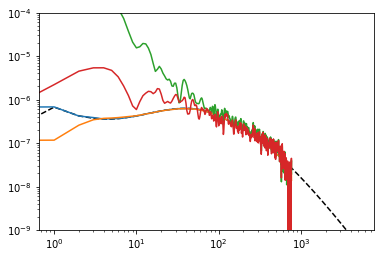

In [70]:
shotnoise = 1.017379567874895e-06


plt.plot(np.mean(cls['full'], axis=0))
plt.plot(np.mean(cls['masked'], axis=0))
plt.plot(cl_true, 'k--', zorder=-1)

for fl in cl_data.files:
    plt.plot((cl_data[fl]-shotnoise)/4.0)

# plt.xlim(-1, 5)
plt.ylim(1.0e-9, 1.0e-4)
plt.xscale('log')
plt.yscale('log')

In [71]:
cls_qso = np.load('./cl_mocks_2k_qso.npz', allow_pickle=True)
cls_fid = np.load('./cl_mocks_1k.npz', allow_pickle=True)

[]

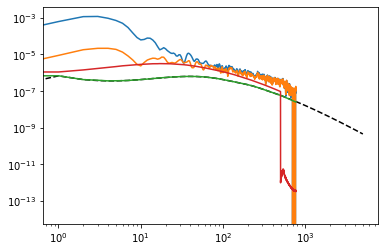

In [76]:
plt.plot(cl_true, 'k--', zorder=-1)
for fl in cl_data.files:
    plt.plot((cl_data[fl]-shotnoise))

for cls_i in [cls_qso, cls_fid]:
    plt.plot(np.mean(cls_i['full'], axis=0))
plt.loglog()